# Tarea 2 - Parte 3
# INF477 Redes Neuronales Artificiales I-2018

Profesor: Dr. Ricardo Ñanculef -- 
Ayudante: Francisco Mena

Alumnos:
- Jose Caimapo, jose.caimapo.12@sansano.usm.cl

- Eliana Providel Godoy, eprovide@inf.utfsm.cl

<h1>Tabla de contenidos<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tarea-2---Parte-3" data-toc-modified-id="Tarea-2---Parte-3-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tarea 2 - Parte 3</a></span></li><li><span><a href="#INF477-Redes-Neuronales-Artificiales-I-2018" data-toc-modified-id="INF477-Redes-Neuronales-Artificiales-I-2018-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>INF477 Redes Neuronales Artificiales I-2018</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Sección-a)-Se-entrena-un-AE-(1-hddn-layer)-para-generar-una-representación-de-MNIST-de-d'-=-2-,8-,32-,64-.-Se-elije-la-función-de-perdida-categorical_crossentropy---y-el-criterio-del-entrenamiento-sigmoid-.-Determine-el-porcentaje-de-compresión-obtneido-y-el-error-de-reconstrucción-en-cada-caso.-Se-mojra-el-resulta-si-elegiumos-un-funcióin-de-activación-reulo-para-el-encoder-o-decoder." data-toc-modified-id="Sección-a)-Se-entrena-un-AE-(1-hddn-layer)-para-generar-una-representación-de-MNIST-de-d'-=-2-,8-,32-,64-.-Se-elije-la-función-de-perdida-categorical_crossentropy---y-el-criterio-del-entrenamiento-sigmoid-.-Determine-el-porcentaje-de-compresión-obtneido-y-el-error-de-reconstrucción-en-cada-caso.-Se-mojra-el-resulta-si-elegiumos-un-funcióin-de-activación-reulo-para-el-encoder-o-decoder.-2.0.0.1"><span class="toc-item-num">2.0.0.1&nbsp;&nbsp;</span>Sección a) Se entrena un AE (1 hddn layer) para generar una representación de MNIST de d' = 2 ,8 ,32 ,64 . Se elije la función de perdida categorical_crossentropy   y el criterio del entrenamiento sigmoid . Determine el porcentaje de compresión obtneido y el error de reconstrucción en cada caso. Se mojra el resulta si elegiumos un funcióin de activación reulo para el encoder o decoder.</a></span></li><li><span><a href="#Sección-b)-Se-comparan-visialmente-la-reconstrucción-que-logra-realizar-el-autoencoder.-Determinar-si-la-percepción-visual-se-corresponde-con-el-error-de-reconstrucción-que-se-observa." data-toc-modified-id="Sección-b)-Se-comparan-visialmente-la-reconstrucción-que-logra-realizar-el-autoencoder.-Determinar-si-la-percepción-visual-se-corresponde-con-el-error-de-reconstrucción-que-se-observa.-2.0.0.2"><span class="toc-item-num">2.0.0.2&nbsp;&nbsp;</span>Sección b) Se comparan visialmente la reconstrucción que logra realizar el autoencoder. Determinar si la percepción visual se corresponde con el error de reconstrucción que se observa.</a></span></li><li><span><a href="#Sección-c)-Se-verifica-la-calidad-de-la-representación-obtenida,-para-ello-se-construye-un-clasificador-kNN." data-toc-modified-id="Sección-c)-Se-verifica-la-calidad-de-la-representación-obtenida,-para-ello-se-construye-un-clasificador-kNN.-2.0.0.3"><span class="toc-item-num">2.0.0.3&nbsp;&nbsp;</span>Sección c) Se verifica la calidad de la representación obtenida, para ello se construye un clasificador kNN.</a></span></li><li><span><a href="#Sección-d)-Deep-encoding,-se-experimenta-el-uso-de-más-de-dos-capas-ocultas-para-demostrar-que-mejora-la-compresión-obtenida-por-PCA,-utilizando-el-mismo-número-de-dimensiones.-Para-ello-se-prueba-con-$d-\in-[2,4,8,16]$-y-distintas-profundidades-$L-\in-[2,3,4]$-y-se-compara-el-desempeño-tanto-en-el-error-de-reconstrucción-como-en-clasificación-via-kNN-de-cada-representación" data-toc-modified-id="Sección-d)-Deep-encoding,-se-experimenta-el-uso-de-más-de-dos-capas-ocultas-para-demostrar-que-mejora-la-compresión-obtenida-por-PCA,-utilizando-el-mismo-número-de-dimensiones.-Para-ello-se-prueba-con-$d-\in-[2,4,8,16]$-y-distintas-profundidades-$L-\in-[2,3,4]$-y-se-compara-el-desempeño-tanto-en-el-error-de-reconstrucción-como-en-clasificación-via-kNN-de-cada-representación-2.0.0.4"><span class="toc-item-num">2.0.0.4&nbsp;&nbsp;</span>Sección d) Deep encoding, se experimenta el uso de más de dos capas ocultas para demostrar que mejora la compresión obtenida por PCA, utilizando el mismo número de dimensiones. Para ello se prueba con $d \in [2,4,8,16]$ y distintas profundidades $L \in [2,3,4]$ y se compara el desempeño tanto en el error de reconstrucción como en clasificación via kNN de cada representación</a></span></li><li><span><a href="#Sección-e)-Se-elije-una-de-las-representaciones-anteriores-y-se-visualizan-usando-la-herramienta-TSNE-disponible-en-la-librería-sklearn.-Para-proceder-con-una-comparación-cualitativa-de-los-resultados-obtenidos-mediante-PCA-y-AE." data-toc-modified-id="Sección-e)-Se-elije-una-de-las-representaciones-anteriores-y-se-visualizan-usando-la-herramienta-TSNE-disponible-en-la-librería-sklearn.-Para-proceder-con-una-comparación-cualitativa-de-los-resultados-obtenidos-mediante-PCA-y-AE.-2.0.0.5"><span class="toc-item-num">2.0.0.5&nbsp;&nbsp;</span>Sección e) Se elije una de las representaciones anteriores y se visualizan usando la herramienta TSNE disponible en la librería sklearn. Para proceder con una comparación cualitativa de los resultados obtenidos mediante PCA y AE.</a></span></li><li><span><a href="#Sección-f)-Por-ultimo-se-modifica-el-primer-autoencoder-(a)-para-trabajar-directamente-sobre-las--imágenes-de-MNIST,-sin-tratarlas-como-vectores,-sino-como-matrices-de-tamaño-1-x-28-x-28.-Es-posible-utilizando-capas-convolucionales-para-definir-el-Encoder-y-el-Decoder." data-toc-modified-id="Sección-f)-Por-ultimo-se-modifica-el-primer-autoencoder-(a)-para-trabajar-directamente-sobre-las--imágenes-de-MNIST,-sin-tratarlas-como-vectores,-sino-como-matrices-de-tamaño-1-x-28-x-28.-Es-posible-utilizando-capas-convolucionales-para-definir-el-Encoder-y-el-Decoder.-2.0.0.6"><span class="toc-item-num">2.0.0.6&nbsp;&nbsp;</span>Sección f) Por ultimo se modifica el primer autoencoder (a) para trabajar directamente sobre las  imágenes de MNIST, sin tratarlas como vectores, sino como matrices de tamaño 1 x 28 x 28. Es posible utilizando capas convolucionales para definir el Encoder y el Decoder.</a></span></li></ul></li><li><span><a href="#Denoising" data-toc-modified-id="Denoising-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Denoising</a></span></li></ul></li></ul></li></ul></div>

In [16]:
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D,UpSampling2D
from keras.datasets import mnist
from keras.utils import np_utils
from keras.metrics import categorical_accuracy, binary_accuracy
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.models import load_model, model_from_json

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.manifold import TSNE

import os
import time
import numpy as np

import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
from importlib import reload
%matplotlib inline

Se cargan los datos desde keras, se normalizan las imagenes de modo que los pixeles queden descritos en el range [0,1], luegos se transforman en vectores unidimensionales y se parten en conjuntos disjuntos de entrenamiento, validación y prueba

In [4]:


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
x_test = x_test.astype('float32') / 255.
#Se extraen datos para hacer el set de validación
# print(x_train.shape)
# print(x_test.shape)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=(1/6))
#como vector
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print('datos de entrenamiento : '+str(x_train.shape)+' '+str(y_train.shape))
print('datos de validacion : '+str(x_val.shape)+' '+str(y_val.shape))
print('datos de pruebas : '+str(x_test.shape)+' '+str(y_test.shape))

datos de entrenamiento : (50000, 28, 28) (50000,)
datos de validacion : (10000, 28, 28) (10000,)
datos de pruebas : (10000, 28, 28) (10000,)


Luego se pasa a usar los datos para una red de autoencoder feed forward, en donde las capas de este son densas. Para esto se re estructuraran los datos de entradas en forma de vector, es decir la matriz de 28 × 28 pasa a ser un vector de 784 componentes.

In [5]:
X_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
X_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
X_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

print('datos de entrenamiento : '+str(X_train.shape)+' '+str(Y_train.shape))
print('datos de validacion : '+str(X_val.shape)+' '+str(Y_val.shape))
print('datos de pruebas : '+str(X_test.shape)+' '+str(Y_test.shape))

datos de entrenamiento : (50000, 784) (50000, 10)
datos de validacion : (10000, 784) (10000, 10)
datos de pruebas : (10000, 784) (10000, 10)


#### Sección a) Se entrena un AE (1 hddn layer) para generar una representación de MNIST de d' = 2 ,8 ,32 ,64 . Se elije la función de perdida categorical_crossentropy   y el criterio del entrenamiento sigmoid . Determine el porcentaje de compresión obtneido y el error de reconstrucción en cada caso. Se mojra el resulta si elegiumos un funcióin de activación reulo para el encoder o decoder.

** revisar si binary-crossentroy o categorical (condiderando que trabaja con múltiples clases)
First, we'll configure our model to use a per-pixel binary crossentropy loss
** Falta % de compresión, a que se refiere

 Sobre jugar con los tamaños del batch, se observa que a menor tamaño el tiempo es mayor, pero se necesitan menos epochs para coverger a un buen resultado. Con tamaños muy grandes del batch, se obtienen aun buenos resultados en los graficos, pero a la hora de gráficar, se observa resultars con el efecto de blur mucho mayor (se probo con 3x epochs que con un batch de 4, 32)

In [6]:
## Completar para mostrar distintos hist para graficar la perdida. 
## Mostrar la matriz de confusión para cada configuración
## sacar conclusiones
#from keras.metrics import categorical_accuracy, binary_accuracy
#from keras.layers import Input, Dense
#from keras.models import Model
#from keras.optimizers import SGD

def plot_data(models,grph):
    #Grafica loss y accuracy para varios modelos
    plt.close('all')
    #axarr.title('MSE vs Epoch')
    f, axarr = plt.subplots(grph, sharex=True, figsize=(15,15))
    f.text(0.5, 0.1, 'epochs', ha='center', va='center')
    f.text(0.06, 0.7, 'loss', ha='center', va='center', rotation='vertical')
    f.text(0.06, 0.3, 'accuracy', ha='center', va='center', rotation='vertical')
    # dict format name: [model history,model time, model score]
    for name,model in models.items():
        #print(model)
        axarr[0].plot(model[0].history['loss'], marker='o', label=name)
        axarr[1].plot(model[0].history['val_loss'], marker='o', label=str('val_')+name)
        axarr[2].plot(model[0].history['binary_accuracy'], marker='o', label=name)
        axarr[3].plot(model[0].history['val_binary_accuracy'], marker='o', label=str('val_')+name)
    f.subplots_adjust(hspace = 0, wspace = 0)
    [axarr[i].legend(loc='center left',bbox_to_anchor=(1, 0.5)) for i in range(grph)]
    [axarr[i].grid(True) for i in range(grph)]
    plt.show()
    
    
def create_model(activation1,activation2,loss,d=32):
    input_img = Input(shape=(784,))    
    encoded = Dense(d, activation=activation1)(input_img)
    decoded = Dense(784, activation=activation2)(encoded)
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(d,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    if loss == 'b':
        autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy',metrics=[binary_accuracy])
    else:
        autoencoder.compile(optimizer=SGD(lr=1.0), loss='categorical_crossentropy',metrics=[binary_accuracy])
    return autoencoder, encoder, decoder

**Siguiente codigo demora en ejecutarse**

In [5]:
modelos = defaultdict(list)
for loss_f in ['b']:
    for activation1 in ['sigmoid','relu']:
        for activation2 in ['sigmoid','relu']:
            name = 'modelo_'+loss_f+'_'+activation1+'_'+activation2
            model, e, d = create_model(activation1,activation2,loss_f)
            #save model
            #print(os.path.join(os.getcwd(), 'exp', 'a','model_weights_'+name+'.h5'))
            model.save_weights(os.path.join(os.getcwd(), 'exp', 'a','model_weights_'+name+'.h5'))
            with open(os.path.join(os.getcwd(), 'exp', 'a', 'model_architecture_'+name+'.json'), 'w') as f:
                f.write(model.to_json())
            #
            start = time.time()
            history =model.fit(X_train, X_train,
                                           epochs=25,
                                           batch_size=128,
                                           shuffle=True,
                                           validation_data=(X_val,X_val),verbose=1)
            modelos[name].append(history)
            modelos[name].append(d)
            modelos[name].append(e)
            modelos[name].append(time.time() - start)
            score = model.evaluate(X_val,X_val)
            modelos[name].append(score)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 41us/step - loss: 0.4038 - binary_accuracy: 0.7773 - val_loss: 0.2972 - val_binary_accuracy: 0.8037
Epoch 2/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.2847 - binary_accuracy: 0.8035 - val_loss: 0.2766 - val_binary_accuracy: 0.8043
Epoch 3/25
50000/50000 [==============================] - 1s 27us/step - loss: 0.2740 - binary_accuracy: 0.8037 - val_loss: 0.2710 - val_binary_accuracy: 0.8045
Epoch 4/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.2702 - binary_accuracy: 0.8038 - val_loss: 0.2684 - val_binary_accuracy: 0.8042
Epoch 5/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.2682 - binary_accuracy: 0.8038 - val_loss: 0.2670 - val_binary_accuracy: 0.8045
Epoch 6/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.2671 - binary_accuracy: 0.8040 - val_loss: 0.2660 - val_binary_a

10000/10000 [==============================] - 1s 54us/step
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 1s 29us/step - loss: 0.3234 - binary_accuracy: 0.7680 - val_loss: 0.2625 - val_binary_accuracy: 0.7988
Epoch 2/25
50000/50000 [==============================] - 1s 26us/step - loss: 0.2451 - binary_accuracy: 0.7965 - val_loss: 0.2275 - val_binary_accuracy: 0.7969
Epoch 3/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.2146 - binary_accuracy: 0.7971 - val_loss: 0.2027 - val_binary_accuracy: 0.7993
Epoch 4/25
50000/50000 [==============================] - 1s 27us/step - loss: 0.1951 - binary_accuracy: 0.7993 - val_loss: 0.1879 - val_binary_accuracy: 0.8010
Epoch 5/25
50000/50000 [==============================] - 1s 27us/step - loss: 0.1825 - binary_accuracy: 0.8013 - val_loss: 0.1770 - val_binary_accuracy: 0.8027
Epoch 6/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.1725

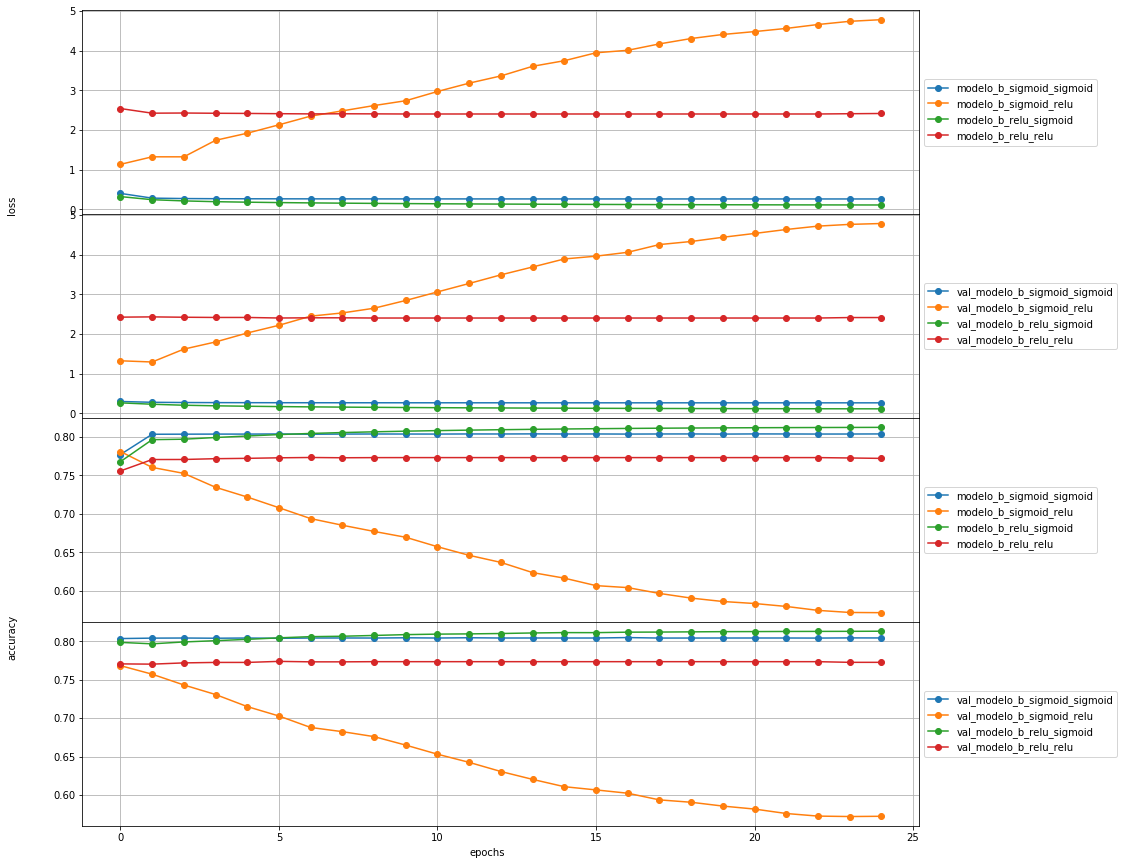

In [20]:
plot_data(modelos,4)

**Siguiente codigo demora en ejecutarse**

In [7]:
# Se experimenta con el cambio de dimension, con distintas configuraciones
# con la capa de activacion del decoder como sigmoid, dado que relu presenta resultados 
# no atrayentes.

modelos_d = defaultdict(list)
for dimension in [8,16,32,64,128]:
    for activation1 in ['sigmoid','relu']:
        for activation2 in ['sigmoid']:
            name = 'modelo_'+loss_f+'_'+activation1+'_'+activation2+'_'+str(dimension)
            model, e, d = create_model(activation1,activation2,'b',dimension)
            #save model
            model.save_weights(os.path.join(os.getcwd(), 'exp', 'a2','model_weights_'+name+'.h5'))
            with open(os.path.join(os.getcwd(), 'exp', 'a2', 'model_architecture_'+name+'.json'), 'w') as f:
                f.write(model.to_json())
            #
            start = time.time()
            history =model.fit(X_train, X_train,
                                           epochs=25,
                                           batch_size=128,
                                           shuffle=True,
                                           validation_data=(X_val,X_val),verbose=0)
            modelos_d[name].append(history)
            modelos_d[name].append(d)
            modelos_d[name].append(e)
            modelos_d[name].append(time.time() - start)
            score = model.evaluate(X_val,X_val)
            modelos_d[name].append(score)

c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


10000/10000 [==============================] - 1s 64us/step


#### Sección b) Se comparan visialmente la reconstrucción que logra realizar el autoencoder. Determinar si la percepción visual se corresponde con el error de reconstrucción que se observa.

In [7]:
def plot_im(model,name,X):
    print(name)
    with open(os.path.join(os.getcwd(), 'exp', 'a', 'model_architecture_'+name+'.json'), 'r') as f:
        autoencoder = model_from_json(f.read())
    autoencoder.load_weights(os.path.join(os.getcwd(), 'exp', 'a','model_weights_'+name+'.h5'))

    encoded_test = model[name][2].predict(X)
    decoded_test = model[name][1].predict(encoded_test)
    
    n = 20
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28),cmap='viridis')
        plt.title('original')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.title('decoded')
        plt.imshow(decoded_test[i].reshape(28, 28),cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

modelo_b_sigmoid_sigmoid


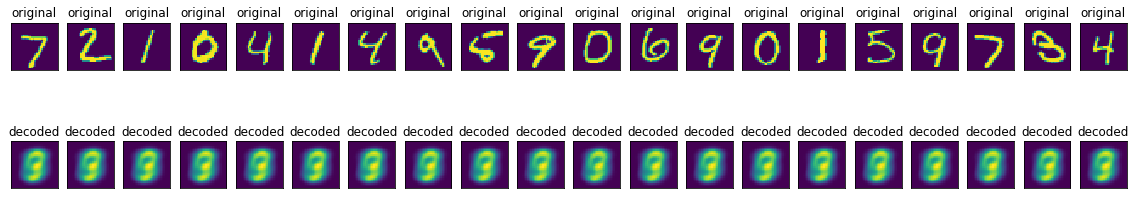

modelo_b_sigmoid_relu


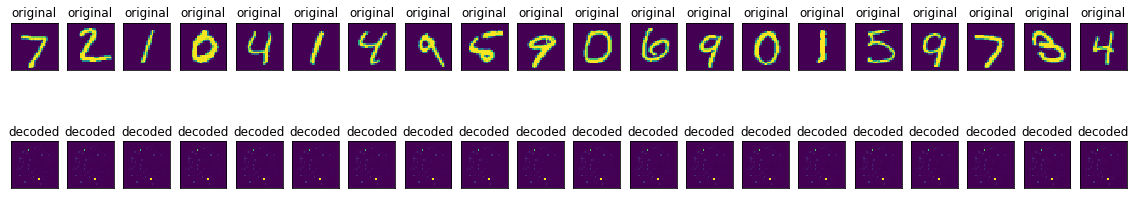

modelo_b_relu_sigmoid


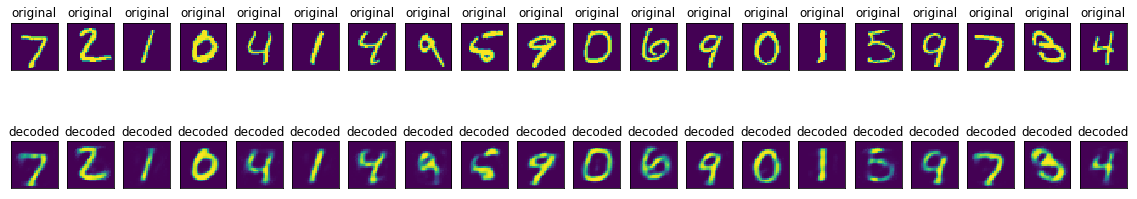

modelo_b_relu_relu


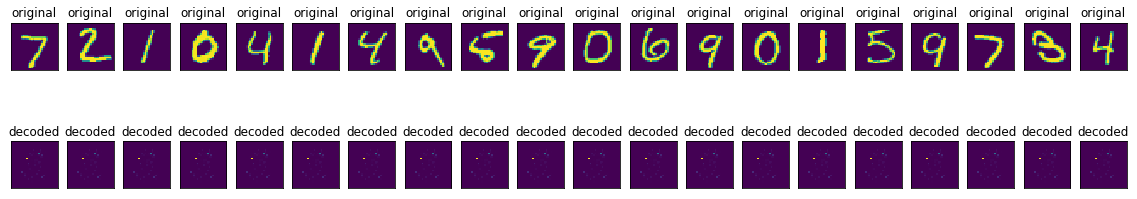

In [25]:
## verificar que encoder y decoder sean los mejores del punto anterior.
## mostra graficamente para las cuatro configuraciones del punto anterior
## seria interesante ver la imagen pequeña

#load other stuff ...
for loss_f in ['b']:
    for activation1 in ['sigmoid','relu']:
        for activation2 in ['sigmoid','relu']:
            name = 'modelo_'+loss_f+'_'+activation1+'_'+activation2
            plot_im(modelos,name,X_test)

#### Sección c) Se verifica la calidad de la representación obtenida, para ello se construye un clasificador kNN.

In [8]:
#from sklearn.decomposition import PCA
#from sklearn.neighbors import KNeighborsClassifier
def calidad(model,name):
    print(name)
    with open(os.path.join(os.getcwd(), 'exp','a','model_architecture_'+str(name)+'.json'), 'r') as f:
        autoencoder = model_from_json(f.read())
    autoencoder.load_weights(os.path.join(os.getcwd(), 'exp','a','model_weights_'+str(name)+'.h5'))
    pca = PCA(n_components=10)
    #PCA
    pca.fit(X_train)
    pca_train = pca.transform(X_train)
    pca_test = pca.transform(X_test)
    #AUTOENCODER
    encoded_train = model[name][2].predict(X_train)
    encoded_test = model[name][2].predict(X_test)
    #CLASIFICATION
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, Y_train)
    print ('Classification Accuracy PCA %.2f' % clf.score(pca_test,Y_test))
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, Y_train)
    print ('Classification Accuracy %.2f' % clf.score(encoded_test,Y_test))

In [11]:
for loss_f in ['b']:
    for activation1 in ['sigmoid','relu']:
        for activation2 in ['sigmoid','relu']:
            name = 'modelo_'+loss_f+'_'+activation1+'_'+activation2
            calidad(modelos,name)

modelo_b_sigmoid_sigmoid
Classification Accuracy PCA 0.91
Classification Accuracy 0.51
modelo_b_sigmoid_relu
Classification Accuracy PCA 0.91
Classification Accuracy 0.81
modelo_b_relu_sigmoid
Classification Accuracy PCA 0.91
Classification Accuracy 0.95
modelo_b_relu_relu
Classification Accuracy PCA 0.91
Classification Accuracy 0.42


**Comentarios**

Falta colocar la conclusión de que AE es peor de KNN (sería interesante poder justificar porque?)

** Quedo que el modelo relu-sigmoid obtiene mejor accuracy con respecto a PCA.

#### Sección d) Deep encoding, se experimenta el uso de más de dos capas ocultas para demostrar que mejora la compresión obtenida por PCA, utilizando el mismo número de dimensiones. Para ello se prueba con $d \in [2,4,8,16]$ y distintas profundidades $L \in [2,3,4]$ y se compara el desempeño tanto en el error de reconstrucción como en clasificación via kNN de cada representación

In [13]:
def get_numeros(numero,dimension):
    if(numero == 2):
        return [dimension, 1000]
    if(numero == 3):
        return [dimension, 500, 1000]
    if(numero == 4):
        return [dimension, 250, 500, 1000]
# Ejemplo de input ['sigmoid','relu'],['sigmoid','sigmoid'],[1000,250],2
def create_deep_model(activation_e, activation_d, dimlist, depth=2):
    input_img = Input(shape=(784,))
    encoded = Dense(dimlist[::-1][0], activation=activation_e[0])(input_img)
    #print('e',dimlist[::-1][0],activation_e[0])
    for i in range(1,depth):
        #print('e',dimlist[::-1][i],activation_e[i])  
        encoded = Dense(dimlist[::-1][i], activation=activation_e[i])(encoded)
    decoded = Dense(dimlist[1:][0], activation=activation_d[0])(encoded)
    #print('d',dimlist[1:][0],activation_d[0])
    for i in range(1,depth):
        if(i+1 == depth):
            #print('d',784,activation_d[::-1][:depth][::-1][i])
            decoded = Dense(784, activation=activation_d[::-1][:depth][::-1][i])(decoded)
        else:
            #print('d',dimlist[1:][i],activation_d[::-1][:depth][::-1][i])
            decoded = Dense(dimlist[i], activation=activation_d[i])(decoded)
    autoencoder = Model(input= input_img, output= decoded)
    encoder = Model(input= input_img, output= encoded)
    encoded_input = Input(shape=(dimlist[0],))
    decoder_layer = autoencoder.layers[-depth](encoded_input)        
    for i in range(1,depth):
        decoder_layer = autoencoder.layers[(-depth)+i](decoder_layer)
    decorder = Model(input= encoded_input,
                     output= decoder_layer)
    autoencoder.compile(optimizer=SGD(lr=1.0),
                        loss='binary_crossentropy',
                        metrics=[binary_accuracy])
    return autoencoder, encoder, decorder

*Siguiente codigo demora en ejecutarse*

Se ejecuta modelos con configuraciones diferentes, diferentes dimensiones, y diferentes numero de capas de profundidad

In [14]:
modelos_profundos = defaultdict(list)
#activations
#activations = ? 17 combinaciones
encoder_activation = ['relu', 'relu', 'relu', 'relu']
decoder_activation = ['relu', 'relu', 'relu', 'sigmoid']
# dimension es el target
for dimension in [2, 4, 8, 16]:
    for layer in [2,3,4]:
            layers = get_numeros(layer,dimension)
            name = 'modelo_'+str(layer)+'-layer_'+str(dimension)+'-targetdim'
            print(name)
            model, e, d =create_deep_model(encoder_activation, 
                                            decoder_activation,
                                            layers, 
                                            layer)
            model.save_weights(os.path.join(os.getcwd(), 'exp','d','weights_'+name+'.h5'))
            with open(os.path.join(os.getcwd(), 'exp','d','architecture_'+name+'.json'), 'w') as f:
                f.write(model.to_json())
            start = time.time()
            history = model.fit(X_train, X_train,
                               epochs = 25,
                               batch_size= 128,
                               shuffle= True,
                               validation_data = (X_val, X_val), verbose = 0)
            modelos_profundos[name].append(history)
            modelos_profundos[name].append(d)
            modelos_profundos[name].append(e)
            modelos_profundos[name].append(time.time() - start)
            score = model.evaluate(X_val,X_val)
            modelos_profundos[name].append(score)   

modelo_2-layer_2-targetdim


c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


10000/10000 [==============================] - 1s 57us/step
modelo_3-layer_2-targetdim
10000/10000 [==============================] - 1s 63us/step
modelo_4-layer_2-targetdim
10000/10000 [==============================] - 1s 62us/step
modelo_2-layer_4-targetdim
10000/10000 [==============================] - 1s 55us/step
modelo_3-layer_4-targetdim
10000/10000 [==============================] - 1s 63us/step
modelo_4-layer_4-targetdim
10000/10000 [==============================] - 1s 69us/step
modelo_2-layer_8-targetdim
10000/10000 [==============================] - 1s 57us/step
modelo_3-layer_8-targetdim
10000/10000 [==============================] - 1s 58us/step
modelo_4-layer_8-targetdim
10000/10000 [==============================] - 1s 61us/step
modelo_2-layer_16-targetdim
10000/10000 [==============================] - 1s 53us/step
modelo_3-layer_16-targetdim
10000/10000 [==============================] - 1s 60us/step
modelo_4-layer_16-targetdim
10000/10000 [===========================

In [55]:
def plot_im_b(model, name, X):
    print(name)
    with open(
            os.path.join(os.getcwd(), 'exp', 'd',
                         'architecture_' + name + '.json'), 'r') as f:
        autoencoder = model_from_json(f.read())
    autoencoder.load_weights(
        os.path.join(os.getcwd(), 'exp', 'd', 'weights_' + name + '.h5'))

    encoded_test = model[name][2].predict(X)
    decoded_test = model[name][1].predict(encoded_test)

    n = 20
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='viridis')
        plt.title('original')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.title('decoded')
        plt.imshow(decoded_test[i].reshape(28, 28), cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


def calidad_d(model, name, d):
    print(name)
    #print(type(d))
    with open(
            os.path.join(os.getcwd(), 'exp', 'd',
                         'architecture_' + str(name) + '.json'), 'r') as f:
        autoencoder = model_from_json(f.read())
    autoencoder.load_weights(
        os.path.join(os.getcwd(), 'exp', 'd', 'weights_' + str(name) + '.h5'))
    #PCA
    pca = PCA(n_components=d)
    pca.fit(X_train)
    pca_train = pca.transform(X_train)
    pca_test = pca.transform(X_test)
    #AUTOENCODER
    encoded_train = model[name][2].predict(X_train)
    encoded_test = model[name][2].predict(X_test)
    #CLASIFICATION
    clf = KNeighborsClassifier(10)
    clf.fit(pca_train, Y_train)
    x=clf.score(pca_test, Y_test)
    print('Classification Accuracy PCA %.2f' % x)
    clf = KNeighborsClassifier(10)
    clf.fit(encoded_train, Y_train)
    y=clf.score(encoded_test, Y_test)
    print('Classification Accuracy %.2f' % y)
    return x,y

modelo_2-layer_2-targetdim


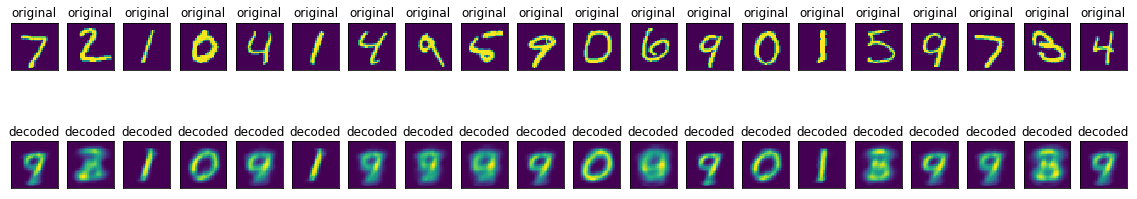

modelo_3-layer_2-targetdim


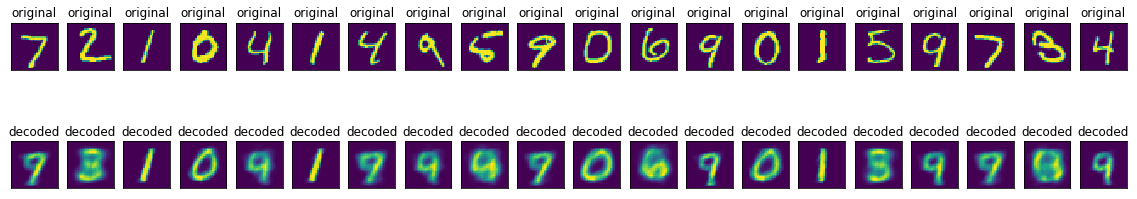

modelo_4-layer_2-targetdim


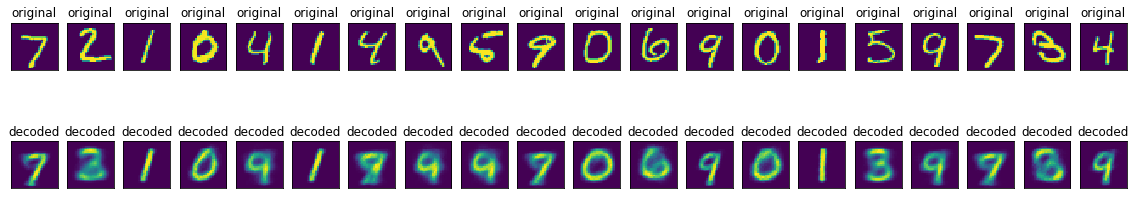

modelo_2-layer_4-targetdim


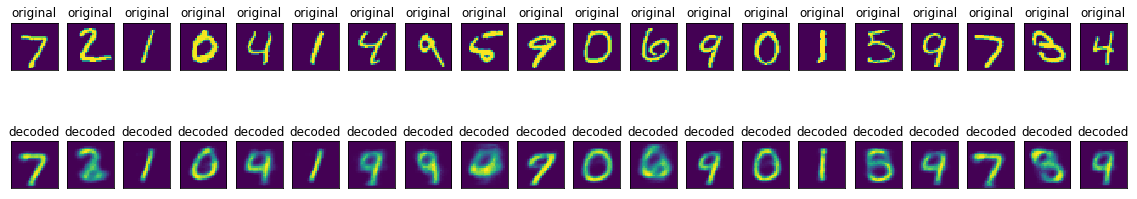

modelo_3-layer_4-targetdim


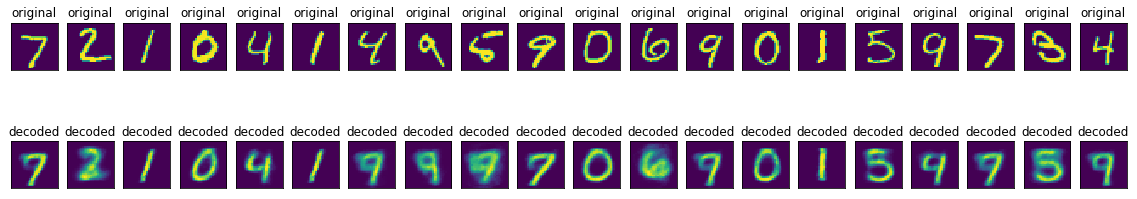

modelo_4-layer_4-targetdim


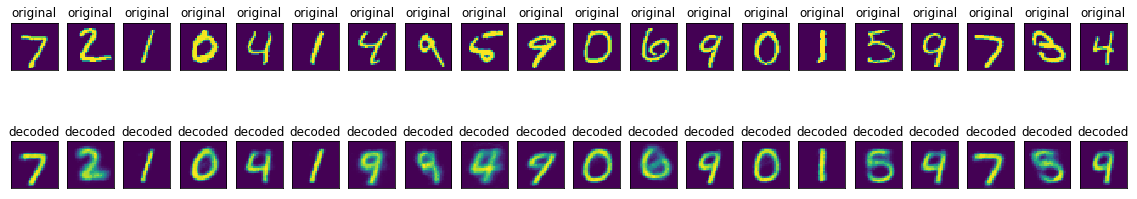

modelo_2-layer_8-targetdim


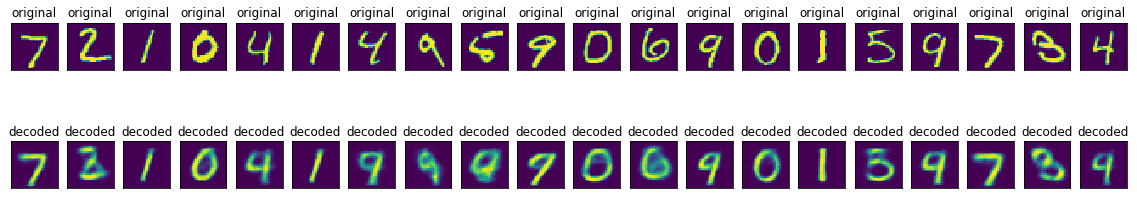

modelo_3-layer_8-targetdim


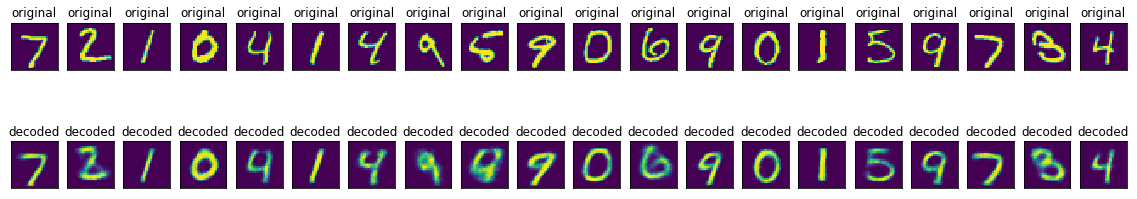

modelo_4-layer_8-targetdim


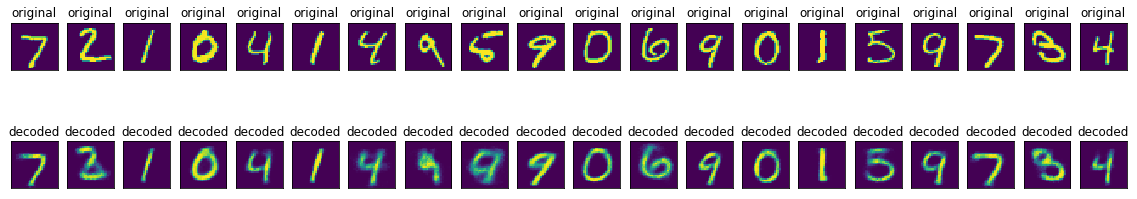

modelo_2-layer_16-targetdim


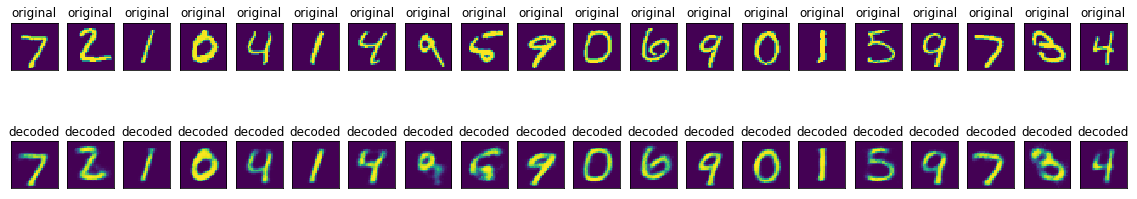

modelo_3-layer_16-targetdim


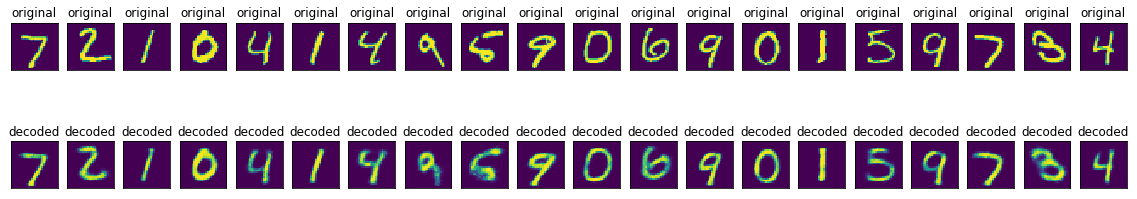

modelo_4-layer_16-targetdim


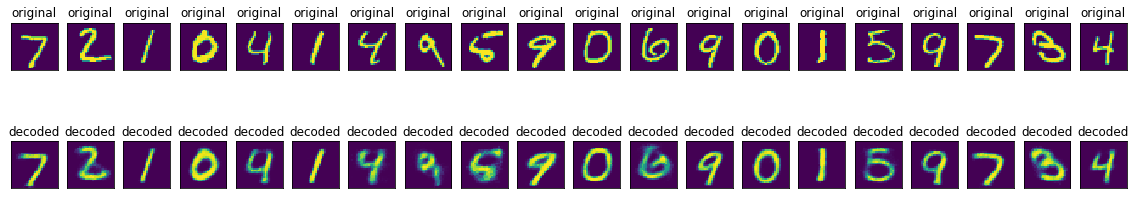

In [29]:
for dimension in [2, 4, 8, 16]:
    for layer in [2,3,4]:
            layers = get_numeros(layer,dimension)
            name = 'modelo_'+str(layer)+'-layer_'+str(dimension)+'-targetdim'
            plot_im_b(modelos_profundos,name,X_test)

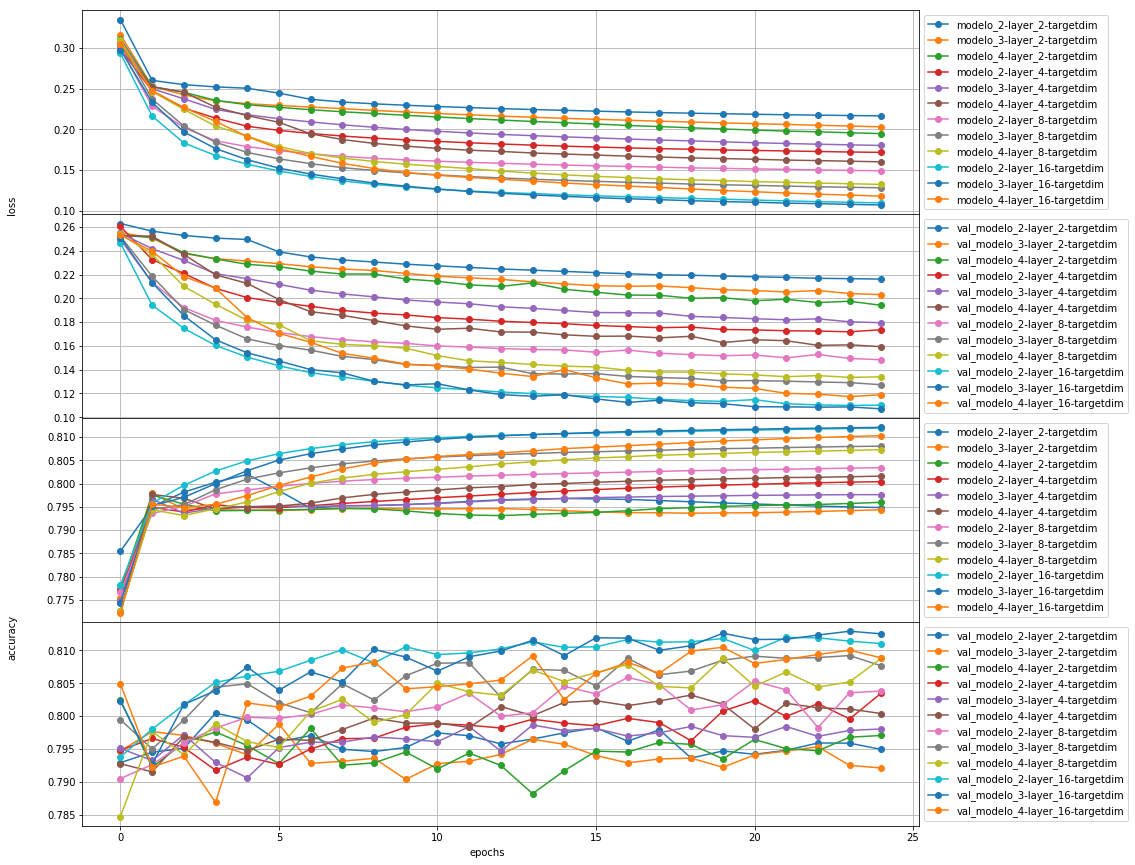

In [18]:
plot_data(modelos_profundos,4)

In [61]:
pca_list = list()
ae_list = list()
for dimension in [2, 4, 8, 16]:
    for layer in [2,3,4]:
        layers = get_numeros(layer,dimension)
        name = 'modelo_'+str(layer)+'-layer_'+str(dimension)+'-targetdim'
        x,y = calidad_d(modelos_profundos,name,dimension)
        pca_list.append(x)
        ae_list.append(y)

modelo_2-layer_2-targetdim
Classification Accuracy PCA 0.26
Classification Accuracy 0.31
modelo_3-layer_2-targetdim
Classification Accuracy PCA 0.26
Classification Accuracy 0.39
modelo_4-layer_2-targetdim
Classification Accuracy PCA 0.26
Classification Accuracy 0.50
modelo_2-layer_4-targetdim
Classification Accuracy PCA 0.52
Classification Accuracy 0.71
modelo_3-layer_4-targetdim
Classification Accuracy PCA 0.52
Classification Accuracy 0.61
modelo_4-layer_4-targetdim
Classification Accuracy PCA 0.52
Classification Accuracy 0.79
modelo_2-layer_8-targetdim
Classification Accuracy PCA 0.87
Classification Accuracy 0.82
modelo_3-layer_8-targetdim
Classification Accuracy PCA 0.87
Classification Accuracy 0.90
modelo_4-layer_8-targetdim
Classification Accuracy PCA 0.87
Classification Accuracy 0.89
modelo_2-layer_16-targetdim
Classification Accuracy PCA 0.95
Classification Accuracy 0.94
modelo_3-layer_16-targetdim
Classification Accuracy PCA 0.95
Classification Accuracy 0.95
modelo_4-layer_16-t

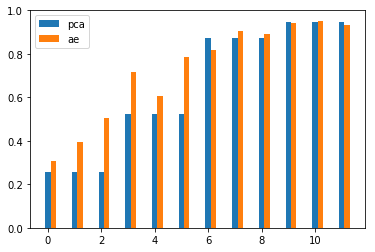

In [72]:
plt.clf()
x = np.arange(len(pca_list))
plt.bar(x,pca_list,width=0.2,label='pca')
plt.bar(x+0.2,ae_list,width=0.2,label='ae')
plt.legend()
plt.show()

Para un target de dimension 2 y 4 se nota que PCA tiene peor comportamiento que Ae, en cambio cuando la dimension del target es 8 y 16, esta situación es diferente, cuando el target es 8, se tiene que PCA es peor solo para un deep encoder de 4 capas, y en el caso de dim16 del target el resultado es a lo más igual que PCA

#### Sección e) Se elije una de las representaciones anteriores y se visualizan usando la herramienta TSNE disponible en la librería sklearn. Para proceder con una comparación cualitativa de los resultados obtenidos mediante PCA y AE.

*Siguiente codigo demora en ejecutarse*

In [73]:
# Modelo profundo 3-layer 16 target dim
encoder_activation = ['relu', 'relu', 'relu', 'relu']
decoder_activation = ['relu', 'relu', 'relu', 'sigmoid']
layers = get_numeros(3, 16)
model, e, d = create_deep_model(encoder_activation, decoder_activation, layers, 3)
history = model.fit(
    X_train,
    X_train,
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=0)

c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [74]:
pca = PCA(n_components=10)
#PCA
pca.fit(X_train)
pca_train = pca.transform(X_train)
pca_test = pca.transform(X_test)
#AUTOENCODER
encoded_train = model.predict(X_train)
encoded_test = model.predict(X_test)
#CLASIFICATION
clf = KNeighborsClassifier(10)
clf.fit(pca_train, Y_train)
print('Classification Accuracy PCA %.2f' % clf.score(pca_test, Y_test))
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, Y_train)
print('Classification Accuracy Encoded %.2f' % clf.score(encoded_test, Y_test))

Classification Accuracy PCA 0.90
Classification Accuracy Encoded 0.94


**Comentario:** se obtiene una mejora en score que obtiene el clasificador KNN

In [92]:
nplot=5000 #warning: mind your memory!
encoded_train = e.predict(X_train[:nplot])

#from sklearn.manifold import TSNE

model_tsne = TSNE(n_components=2, random_state=0, n_iter=5000)
encoded_train_tsne = model_tsne.fit_transform(encoded_train)
#fig = plt.figure(figsize=(10, 10))
#tsne_ax = fig.add_subplot(121)
#pca_ax = fig.add_subplot(122)
#colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
#markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
pca = PCA(n_components=16)
pca.fit(X_train)
pca_train_p = pca.transform(X_train)
encoded_train_p = model_tsne.fit_transform(pca_train_p[:nplot])

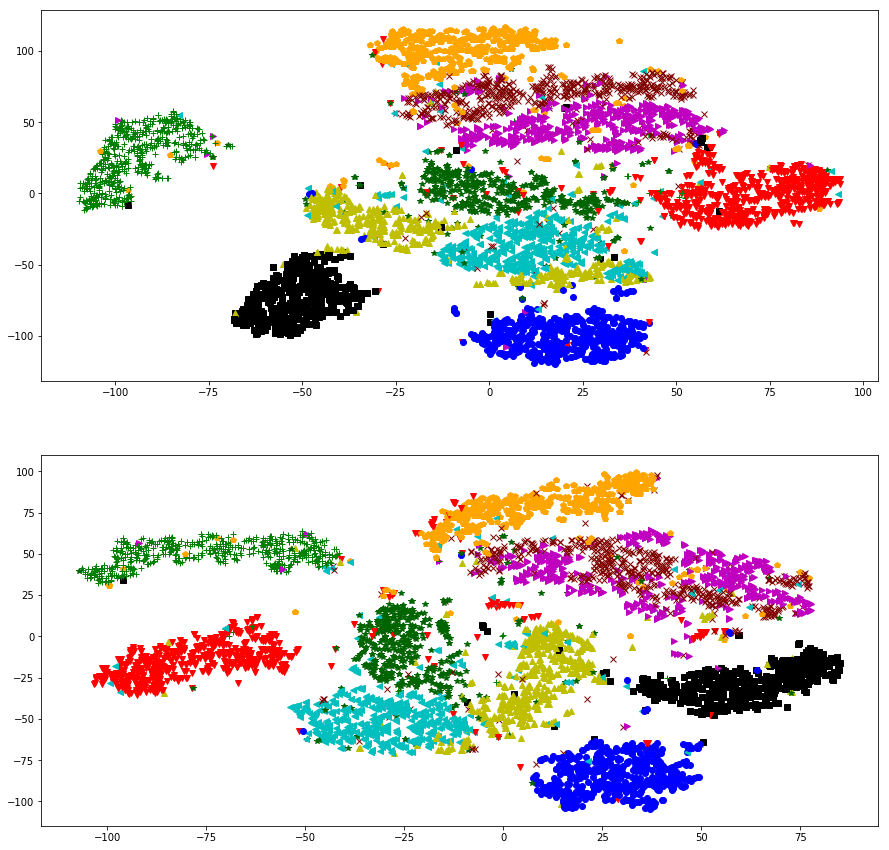

In [93]:
plt.clf()
nplot=5000
fig = plt.figure(figsize=(15, 15))
tsne_ax = fig.add_subplot(211)
pca_ax = fig.add_subplot(212)
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}

for idx in range(0,nplot):
    label = y_train[idx]
    tsne_ax.plot(encoded_train_tsne[idx][0], encoded_train_tsne[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

#plot PCA
for idx in range(0,nplot):
    label = y_train[idx]
    pca_ax.plot(encoded_train_p[idx][0], encoded_train_p[idx][1],
        color=colors[label], marker=markers[label], markersize=6)

plt.show()

Visualmente usando el mismo número de componentes se puede apreciar que la visualización del autoencoder más la reducción al subespacio por parte de TSNE se observan cumulos más homogeneos en la zona 50,50

#### Sección f) Por ultimo se modifica el primer autoencoder (a) para trabajar directamente sobre las  imágenes de MNIST, sin tratarlas como vectores, sino como matrices de tamaño 1 x 28 x 28. Es posible utilizando capas convolucionales para definir el Encoder y el Decoder.

**Duda** Al usar las imágenes directamente, deberia cambiarse la función de perdida?



In [53]:
#from keras.layers.core import Dense, Dropout, Activation, Flatten
#from keras.layers import Input, Dense
#from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D,UpSampling2D

In [55]:
X_train_ = x_train.astype('float32') / 255.
X_test_ = x_test.astype('float32') / 255.
X_val_ = x_val.astype('float32') / 255.
X_train_ = np.reshape(X_train_, (len(X_train_), 28, 28, 1)) #modify for th dim ordering
X_test_ = np.reshape(X_test_, (len(X_test_), 28, 28, 1))
X_val_ = np.reshape(X_val_, (len(X_val_), 28, 28, 1))
input_img_ = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img_)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img_, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 8)         0         
__________

c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same")`
  if __name__ == '__main__':


**Correr 1 vez.. se demora como media hora **

In [57]:
histo = autoencoder.fit(X_train_,X_train_,epochs=30,batch_size=32,shuffle=True,validation_data=(X_val_, X_val_))
autoencoder.save(os.path.join(os.getcwd(), 'exp', 'f','modelo_convolucional.h5'))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 25s 502us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 2/30
50000/50000 [==============================] - 25s 503us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 3/30
50000/50000 [==============================] - 25s 500us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 4/30
50000/50000 [==============================] - 25s 500us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 5/30
50000/50000 [==============================] - 25s 499us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/30
50000/50000 [==============================] - 25s 502us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 7/30
50000/50000 [==============================] - 25s 502us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 8/30
50000/50000 [==============================] - 25s 504us/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/30
50000/50000 [==============================] - 25s 503us/step - loss: 0.0040 - val_

OSError: Unable to create file (unable to open file: name = 'C:\Users\Caimapo\Desktop\U\ML\Tarea 2\Part 3 Autoencoders (AEs) in MNIST\exp\f\modelo_convolucional.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [82]:
autoencoder.save(os.path.join(os.getcwd(), 'exp', 'f','modelo_convolucional.h5'))

**Carga el modelo corrido**

In [87]:
autoencoder = load_model(os.path.join(os.getcwd(), 'exp', 'f', 'modelo_convolucional.h5'))

input_img = autoencoder.input
encoder_layer = autoencoder.layers[-6]
encoder = Model(inputs=input_img, outputs=encoder_layer(autoencoder.layers[-7].output))
# Pasa de 28x28x1 a 7x7x8
encoded_test = encoder.predict(X_test_).reshape(len(X_test_),7*7*8)
encoded_train = encoder.predict(X_train_).reshape(len(X_train_),7*7*8)
print(encoded_train.shape)

clf = KNeighborsClassifier(10)
clf.fit(encoded_train, Y_train)
print('Encoder Accuracy  = %.2f' %( clf.score(encoded_test,Y_test)))

pca = PCA(n_components=16)
#PCA
pca.fit(X_train)
pca_train = pca.transform(X_train)
pca_test = pca.transform(X_test)

clf = KNeighborsClassifier(10)
clf.fit(pca_train, Y_train)
print('PCA Accuracy  = %.2f' %( clf.score(pca_test,Y_test)))

(50000, 392)
Encoder Accuracy  = 0.93
PCA Accuracy  = 0.97


Se evalua el desempeño del autoencoder convolucional entrenado, mediante el clasificador k-NN para la representación vectorial (flatten) de 7x7x8, obteniendo un valor de 93%, el mismo cuando se trabaja sobre la representación original de los datos (28x28).

### Denoising
Como se ha discutido en clases, un denoising autoencoder (dAE) es esencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

##### > a) Genere artificialmente una versión corrupta de las imágenes en MNIST utilizando el siguiente modelo de ruido (masking noise): si $x\in {\rm I\!R}^d$ es una de las imágenes originales, la versión ruidosa $\~{x}$ se obtiene como $\~{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.

In [94]:
from numpy.random import binomial
def noise_maker(p=0.1):
    noise_level = p
    noise_mask = binomial(n=1,p=noise_level,size=X_train.shape)
    noisy_x_train = X_train*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=X_val.shape)
    noisy_x_val = X_val*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=X_test.shape)
    noisy_x_test = X_test*noise_mask
    return noisy_x_train,noisy_x_val,noisy_x_test

##### > b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. Experimente diferentes valores de *p* en el rango (0, 1).

c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


10000/10000 [==============================] - 1s 92us/step
modelo_b_relu_sigmoid_16_p:0.0
Error de decodificación: 0.792795027065


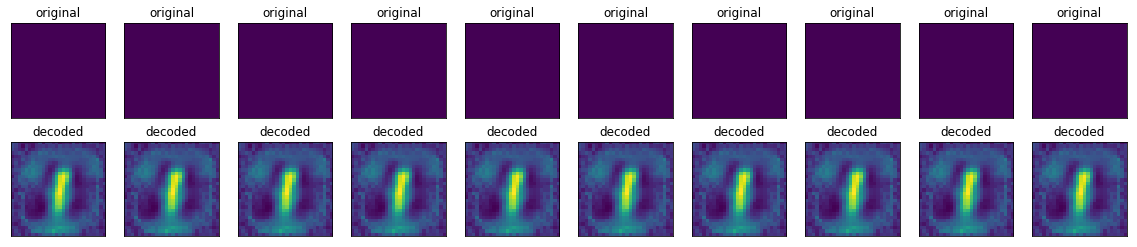

10000/10000 [==============================] - 1s 91us/step
modelo_b_relu_sigmoid_16_p:0.142857142857
Error de decodificación: 0.800614539146


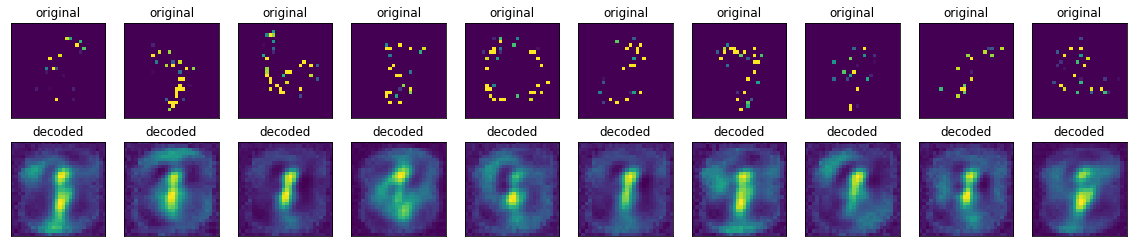

10000/10000 [==============================] - 1s 88us/step
modelo_b_relu_sigmoid_16_p:0.285714285714
Error de decodificación: 0.805179720402


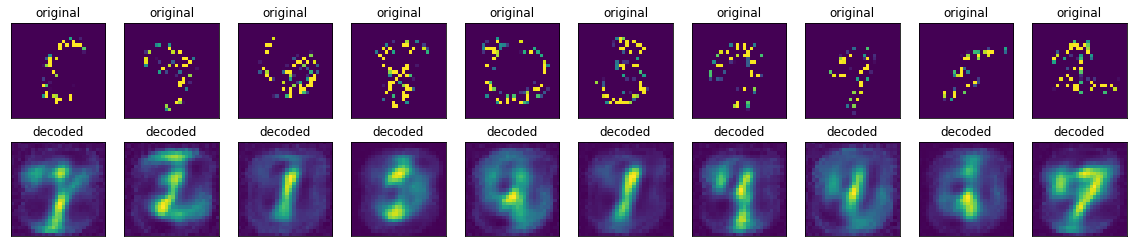

10000/10000 [==============================] - 1s 83us/step
modelo_b_relu_sigmoid_16_p:0.428571428571
Error de decodificación: 0.807216070271


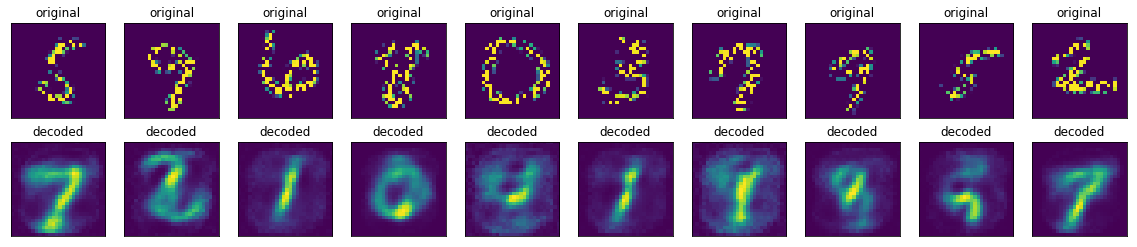

10000/10000 [==============================] - 1s 88us/step
modelo_b_relu_sigmoid_16_p:0.571428571429
Error de decodificación: 0.806344261169


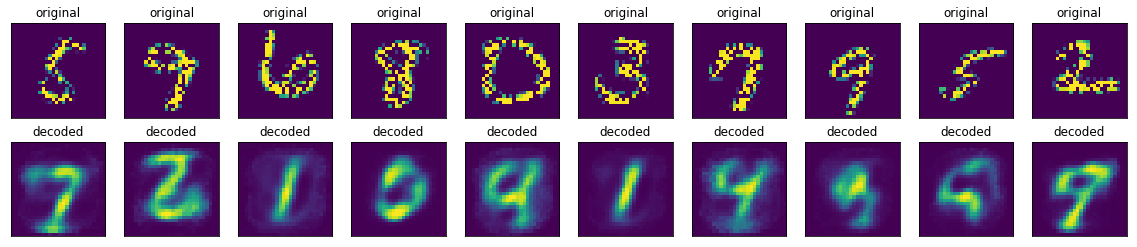

10000/10000 [==============================] - 1s 87us/step
modelo_b_relu_sigmoid_16_p:0.714285714286
Error de decodificación: 0.80754821558


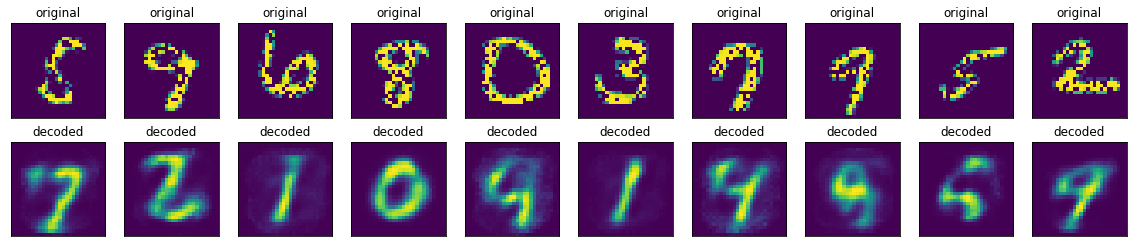

10000/10000 [==============================] - 1s 78us/step
modelo_b_relu_sigmoid_16_p:0.857142857143
Error de decodificación: 0.804779338074


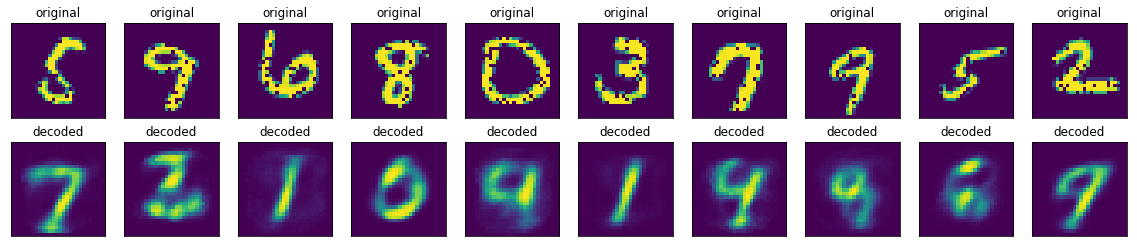

10000/10000 [==============================] - 1s 83us/step
modelo_b_relu_sigmoid_16_p:1.0
Error de decodificación: 0.806144260502


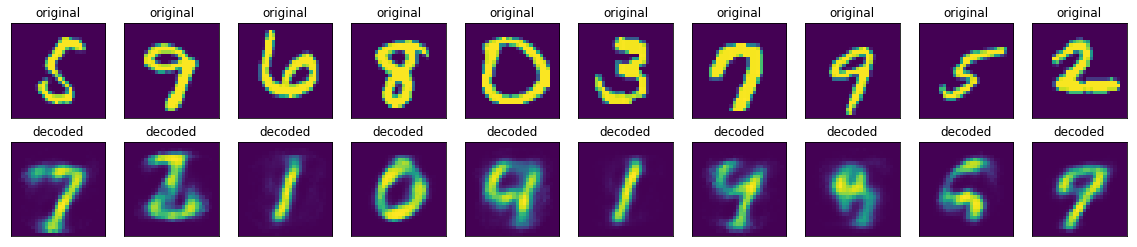

In [106]:
modelos_denoising = defaultdict(list)
for p in np.linspace(0, 1, 8):
    noisy_x_train, noisy_x_val, noisy_x_test = noise_maker(p)
    name = 'modelo_b_relu_sigmoid_16_p:' + str(p)
    model, e, d = create_model(activation1, activation2, 'b', 16)
    #save model
    model.save_weights(
        os.path.join(os.getcwd(), 'exp', 'de',
                     'model_weights_' + name + '.h5'))
    with open(
            os.path.join(os.getcwd(), 'exp', 'de',
                         'model_architecture_' + name + '.json'), 'w') as f:
        f.write(model.to_json())
        #
    start = time.time()
    history = model.fit(
        X_train,
        X_train,
        epochs=25,
        batch_size=256,
        shuffle=True,
        validation_data=(X_val, X_val),
        verbose=0)
    modelos_denoising[name].append(history)
    modelos_denoising[name].append(d)
    modelos_denoising[name].append(e)
    modelos_denoising[name].append(time.time() - start)
    score = model.evaluate(noisy_x_test, X_test)
    modelos_denoising[name].append(score)
    n = 10
    encoded_test = e.predict(noisy_x_test)
    decoded_test = d.predict(encoded_test)
    print(name)
    print('Error de decodificación: '+str(score[1]))
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_train[i].reshape(28, 28), cmap='viridis')
        plt.title('original')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.title('decoded')
        plt.imshow(decoded_test[i].reshape(28, 28), cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [99]:
def plot_im_noise(model, name, X):
    print('*'*20)
    print(name)
    print('Error de decodificación: '+str(model[name][4]))
    encoded_test = model[name][2].predict(X)
    decoded_test = model[name][1].predict(encoded_test)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='viridis')
        plt.title('original')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.title('decoded')
        plt.imshow(decoded_test[i].reshape(28, 28), cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Como se puede ver en las imagenes

##### > c) Utilice estas imágenes intencionalmente corruptas para entrenar un AE con fines de reducción de dimensionalidad. Durante el entrenamiento, proceda exactamente como en (b), pero su objetivo no será hacer *denoising* sino obtener una representación comprimida de alta calidad de las imágenes originales. Al final del entrenamiento, mida el error de reconstrucción como el desempeño en clasificación (vı́a kNN como en la sección anterior) de la representación obtenida. Comente.

In [ ]:
noisy_x_train,noisy_x_val,noisy_x_test = noise_maker(0.5)
input_img = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
hist = autoencoder.fit(noisy_x_train,x_train, epochs=40, batch_size=25,
    shuffle=True, validation_data=(noisy_x_val, x_val))
autoencoder.save(os.path.join(os.getcwd(), 'exp', 'denoising', 'model_with_noise.h5'))

In [ ]:
for i in range(1,11):
    #autoencoder
    n = 10
    plt.figure(figsize=(20, 4))
    score = autoencoder.evaluate(noisy_x_test,x_test,verbose=0)
    
    print("Error de reconstrucción="+str(score))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Corrupta")
    
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    
        plt.title("Reconstruida")
    plt.show()



In [ ]:
encoded_train = encoder.predict(noisy_x_train)
encoded_test = encoder.predict(noisy_x_test)
score = autoencoder.evaluate(noisy_x_test,x_test,verbose=0)
print(score)
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, Y_train)
print('Classification Accuracy K-vecinos %.2f' % clf.score(encoded_test,Y_test))

##### > d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes

In [ ]:
def plot_images(images, cls_true, cls_pred=None, noise=0.0):
    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        image = images[i].reshape(img_shape)
        image += noise

        image = np.clip(image, 0.0, 1.0)
        ax.imshow(image, cmap='binary', interpolation='nearest')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)

        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [ ]:
images = X_train.images[0:9]
cls_true = data.test.cls[0:9]